In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, StructType, StructField, TimestampType, IntegerType
from pyspark.sql.functions import from_json, col

# Define the path to the jars on the EC2 instance
spark_jars_path = "/home/ec2-user/stream-processing-template/jars"  # <-- Update this path

spark = SparkSession.builder.appName("retail_pysaprk_consumer") \
    .config("spark.jars", f"{spark_jars_path}/commons-pool2-2.11.1.jar,"
            f"{spark_jars_path}/spark-sql-kafka-0-10_2.12-3.4.0.jar,"
            f"{spark_jars_path}/spark-streaming-kafka-0-10-assembly_2.12-3.4.0.jar") \
    .getOrCreate()


23/12/13 14:28:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
/usr/local/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


In [2]:
import time
# Define the schema for our data
schema = StructType([
    StructField("store_location", StringType(), True),
    StructField("time_of_purchase", TimestampType(), True),
    StructField("product_ID", StringType(), True),
    StructField("transaction_amount", IntegerType(), True)
])

# Stream from Kafka topic
df = spark.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "b-1.monstercluster1.6xql65.c3.kafka.eu-west-2.amazonaws.com:9092") \
    .option("subscribe", "retail_transactions") \
    .load()

In [3]:
transactions = (df.selectExpr("CAST(value AS STRING)")
                .withColumn("data", from_json(col("value"), schema))
                .select("data.*").limit(10))

query = transactions.writeStream \
    .format("memory") \
    .queryName("query_1") \
    .start()

query.awaitTermination(15)

23/12/13 14:28:33 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-eae6571e-e30e-47a4-92a2-dc07017279ac. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
23/12/13 14:28:33 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
23/12/13 14:28:37 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


False

In [4]:
processed_data = spark.sql("SELECT * FROM query_1")

In [5]:
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

transactions = processed_data.withColumn("transaction_amount", col("transaction_amount").cast(DoubleType()))
df = transactions.toPandas()

In [6]:
from pyspark.sql.functions import sum
total_transactions = transactions.groupBy("store_location").agg(sum("transaction_amount").alias("total_amount"))
total_transactions.show()

+--------------+------------+
|store_location|total_amount|
+--------------+------------+
|       Phoenix|       360.0|
|   San Antonio|      1701.0|
|   Los Angeles|       637.0|
|       Chicago|      -578.0|
+--------------+------------+



In [7]:
transaction_counts = transactions.groupBy("store_location").count().withColumnRenamed("count", "transaction_count")
transaction_counts.show()

+--------------+-----------------+
|store_location|transaction_count|
+--------------+-----------------+
|       Phoenix|                2|
|   San Antonio|                4|
|   Los Angeles|                1|
|       Chicago|                1|
+--------------+-----------------+



In [8]:
from pyspark.sql.functions import avg
average_transactions = transactions.groupBy("store_location").agg(avg("transaction_amount").alias("average_amount"))
average_transactions.show()

+--------------+--------------+
|store_location|average_amount|
+--------------+--------------+
|       Phoenix|         318.0|
|   San Antonio|         494.5|
|   Los Angeles|         637.0|
|       Chicago|        -578.0|
+--------------+--------------+



In [9]:
with_discount = transactions.withColumn("discounted_amount", col('transaction_amount') * 0.9)
with_discount.show()

+--------------+-------------------+----------+------------------+-----------------+
|store_location|   time_of_purchase|product_ID|transaction_amount|discounted_amount|
+--------------+-------------------+----------+------------------+-----------------+
|       Phoenix|2023-12-13 14:28:39|    P00076|              22.0|             19.8|
|       Chicago|2023-12-13 14:28:41|    P00037|            -578.0|           -520.2|
|   San Antonio|2023-12-13 14:28:43|    P00070|             901.0|            810.9|
|   Los Angeles|2023-12-13 14:28:45|    P00037|             637.0|573.3000000000001|
|   San Antonio|2023-12-13 14:28:48|    P00037|             473.0|            425.7|
|   San Antonio|2023-12-13 14:28:50|    P00001|             327.0|            294.3|
|       Phoenix|2023-12-13 14:28:52|    P00025|             338.0|            304.2|
|   San Antonio|2023-12-13 14:28:54|    P00050|             277.0|            249.3|
|       Phoenix|2023-12-13 14:28:56|    P00055|             594.0

In [10]:
phys_transactions = with_discount.filter(col('store_location') != "online")
phys_transactions.show()

+--------------+-------------------+----------+------------------+-----------------+
|store_location|   time_of_purchase|product_ID|transaction_amount|discounted_amount|
+--------------+-------------------+----------+------------------+-----------------+
|       Phoenix|2023-12-13 14:28:39|    P00076|              22.0|             19.8|
|       Chicago|2023-12-13 14:28:41|    P00037|            -578.0|           -520.2|
|   San Antonio|2023-12-13 14:28:43|    P00070|             901.0|            810.9|
|   Los Angeles|2023-12-13 14:28:45|    P00037|             637.0|573.3000000000001|
|   San Antonio|2023-12-13 14:28:48|    P00037|             473.0|            425.7|
|   San Antonio|2023-12-13 14:28:50|    P00001|             327.0|            294.3|
|       Phoenix|2023-12-13 14:28:52|    P00025|             338.0|            304.2|
|   San Antonio|2023-12-13 14:28:54|    P00050|             277.0|            249.3|
|       Phoenix|2023-12-13 14:28:56|    P00055|             594.0

In [13]:
#group and agg
store_sales = phys_transactions.groupBy("store_location").agg({"discounted_amount": "sum"})

store_sales.show()

+--------------+----------------------+
|store_location|sum(discounted_amount)|
+--------------+----------------------+
|       Phoenix|                 858.6|
|   San Antonio|    1780.1999999999998|
|   Los Angeles|     573.3000000000001|
|       Chicago|                -520.2|
|      New York|                  73.8|
+--------------+----------------------+



<Figure size 1200x600 with 0 Axes>

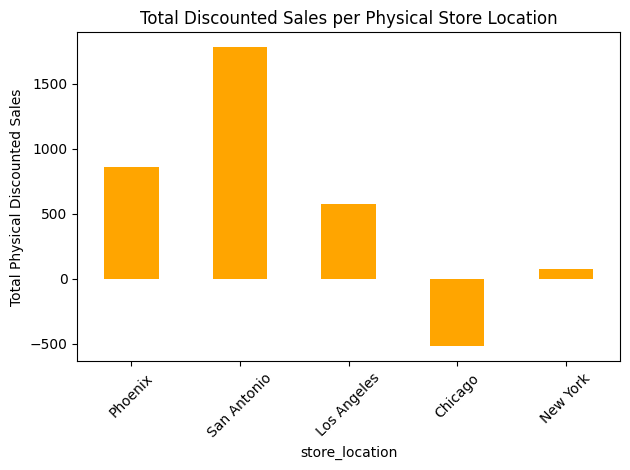

In [14]:
#convert to pd df
store_sales_pd = store_sales.toPandas()

#plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
store_sales_pd.plot(kind='bar', x='store_location', y='sum(discounted_amount)', legend=False, color='orange')
plt.ylabel('Total Physical Discounted Sales')
plt.title('Total Discounted Sales per Physical Store Location')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()